In [1]:
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time

%matplotlib inline

In [2]:
import dataset
import torch
import torchvision.transforms as transforms
from dataset import custom_transforms

from utils.data_manipulation import add_dist_along_vector, add_dict_perpendicular_vector, rotate_point_by_angle
from utils.data_manipulation import get_object_aligned_box, plot_image_coordinates

from core.evaluate import normalize_theta

In [3]:
from config.default import _C as cfg
cfg.merge_from_file('config/seadragon.yaml')

In [19]:
#cfg.DATASET.NAME = 'mantaray' #'hammerhead' 'seadragon'#
cfg.LOCAL = True
cfg.DATA_DIR = '../data'
cfg.TRAIN.BS = 4
cfg.TEST.BS = 4

# Custom transforms unit testing

In [5]:
from dataset.animal import AnimalDataset
train_dataset = AnimalDataset(cfg, cfg.DATASET.TRAIN_SET, None)
#valid_dataset = AnimalDataset(cfg, cfg.DATASET.VALID_SET, None)

In [6]:
from dataset.custom_transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotate, RandomScale, Resize
from dataset.custom_transforms import CropObjectAlignedArea, ResizeKeepRatio, ColorJitterSample

In [7]:
tf_test = { 'ColorJitter1': ColorJitterSample(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
            'ColorJitter2': ColorJitterSample(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
            'ColorJitter3': ColorJitterSample(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
            'Horizontal flip': RandomHorizontalFlip(p=1.), 
            'Vertical flip': RandomVerticalFlip(p=1.),
            'RandomRotations': RandomRotate(degrees=90),
            'RandomScale': RandomScale(scale=(0.8, 1.2)),
            'Resize': Resize(256),
            'ResizeKeepRatio': ResizeKeepRatio(256),
            'CropObjectArea': CropObjectAlignedArea(0., 1.),
}

/home/olga/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/olga/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/olga/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/olga/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/olga/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


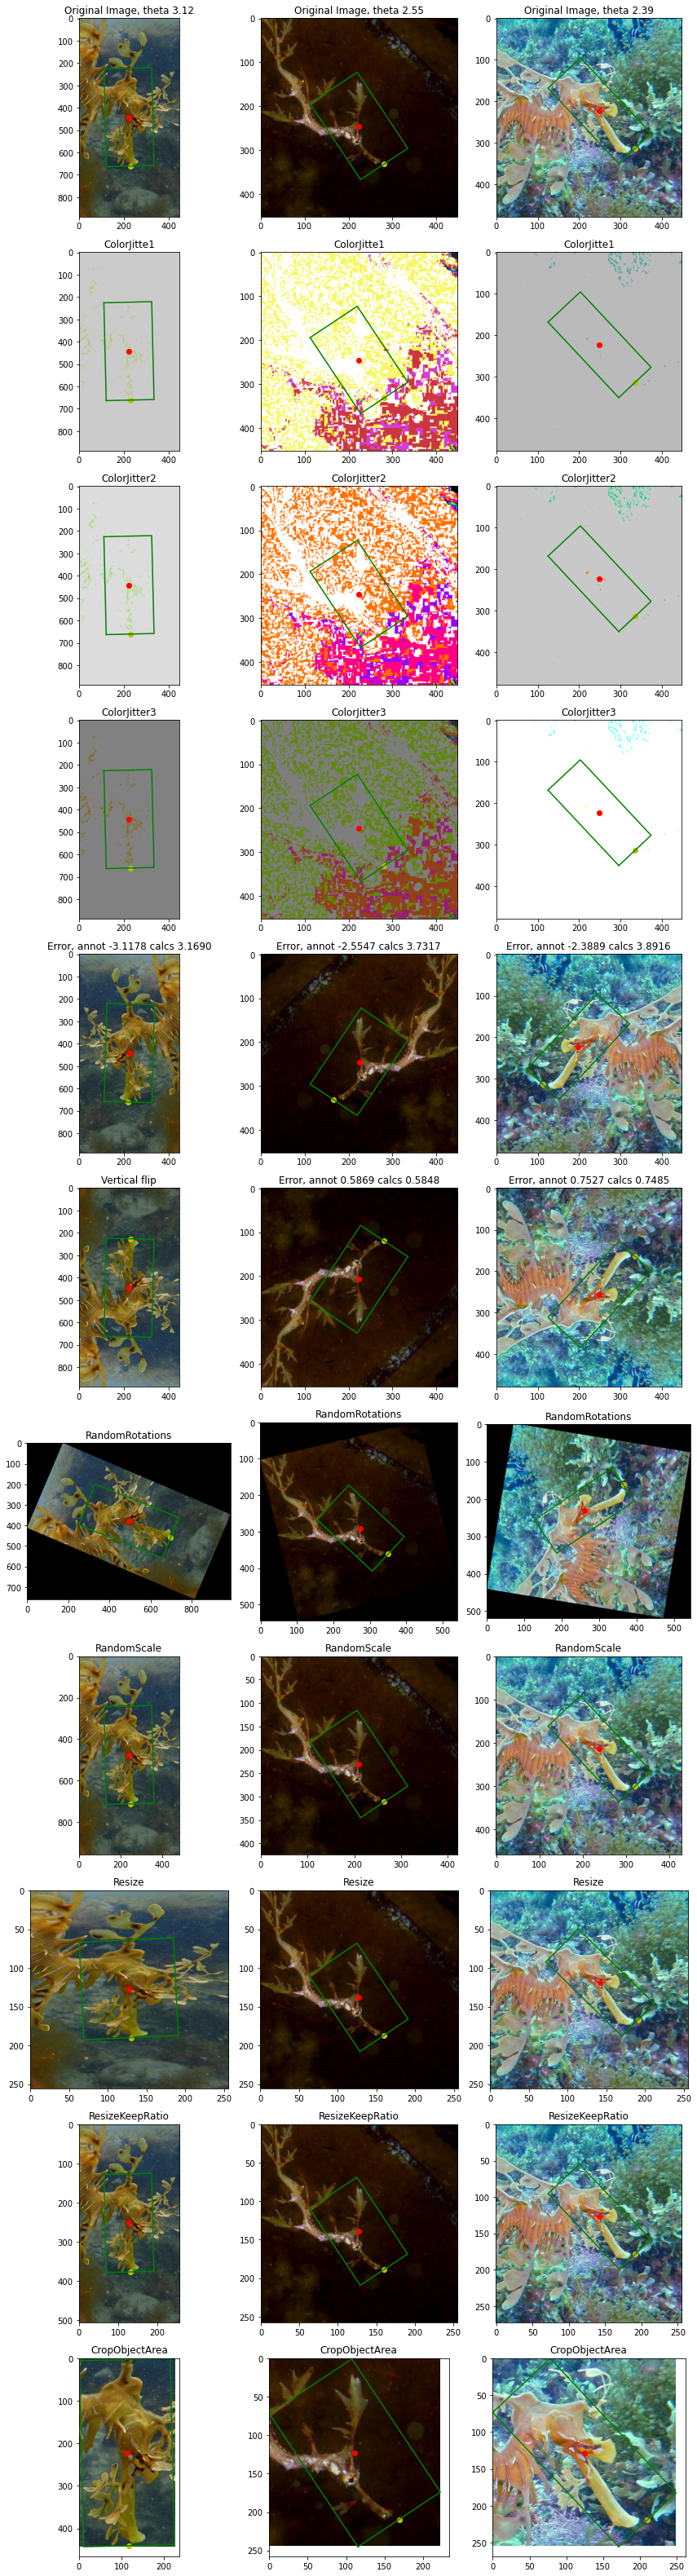

In [9]:
fig, ax = plt.subplots(nrows=len(tf_test)+1, ncols=3, figsize=(3*4, (len(tf_test)+1)*4))
for c in range(3):
    image, xc, yc, xt, yt, w, theta = train_dataset[random.randint(0, len(train_dataset)-1)]
    plot_image_coordinates(ax[0, c], image, xc, yc, xt, yt, w)
    theta_coord = np.arctan2(yt-yc, xt-xc) + math.radians(90)
    
    if abs(theta_coord - theta) < 1e-3:
        ax[0,c].set_title('Original Image, theta {:.2f}'.format(theta))
    else:
        ax[0,c].set_title('Error, annot {:.2f} calcs {:.2f}'.format(theta, theta_coord))
        
    r = 1
    for name, tf in tf_test.items():
        #Apply transformation
        image_, xc_, yc_, xt_, yt_, w_, theta_ = tf((image, xc, yc, xt, yt, w, theta))
        plot_image_coordinates(ax[r, c], image_, xc_, yc_, xt_, yt_, w_)
        #Verify that theta after transform is correct
        theta_aug = np.arctan2(yt_-yc_, xt_-xc_) + math.radians(90)
        #print('annot {:.2f} cals {:.2f} {}'.format(theta_, theta_aug, abs(theta_aug - theta_)))
        if abs(normalize_theta(theta_aug, False) - normalize_theta(theta_, False)) < 1e-3:
            ax[r,c].set_title(name)
        else:
            ax[r,c].set_title('Error, annot {:.4f} calcs {:.4f}'.format(theta_, theta_aug))
        r += 1

plt.tight_layout()

In [11]:
plt.bar(d.keys(), d.values(), width=10, align='edge')

NameError: name 'd' is not defined

# Test annotations (computed theta vs gt_theta)

In [31]:
n_test = 100
for i in range(n_test):
    image, xc, yc, xt, yt, w, theta = train_dataset[i]
    theta_coord = np.arctan2(yt-yc, xt-xc) + math.radians(90)
    theta = normalize_theta(theta, False)
    theta_coord = normalize_theta(theta_coord, False)
    
    #Check annotations
    if abs(theta_coord - theta) > 1e-2:
        print('ID {} Initial Annot Error, annot {:.2f} calcs {:.2f}'.format(i, theta, theta_coord))
        
    tf = random.choice(list(tf_test.values()))
    #Apply transformation
    image_, xc_, yc_, xt_, yt_, w_, theta_ = tf((image, xc, yc, xt, yt, w, theta))
    #Verify that theta after transform is correct
    theta_aug = np.arctan2(yt_-yc_, xt_-xc_) + math.radians(90)
    theta_aug = normalize_theta(theta_aug, False)
    theta_ = normalize_theta(theta_, False)

    if abs(theta_aug - theta_) > 1e-2:
        print('ID {} Error, annot {:.4f} calcs {:.4f}'.format(i, theta_, theta_aug))

# Data Loader test

In [20]:
train_transform = transforms.Compose([
                        #custom_transforms.CropObjectAlignedArea(scale=2.),
                        #custom_transforms.ResizeKeepRatio(min_size=2*cfg.MODEL.IMSIZE[0]),
                        custom_transforms.RandomHorizontalFlip(p=cfg.DATASET.HOR_FLIP_PROB),
                        custom_transforms.RandomVerticalFlip(p=cfg.DATASET.VERT_FLIP_PROB),
                        custom_transforms.RandomRotate(degrees=cfg.DATASET.MAX_ROT, mode = 'edge'),
                        custom_transforms.RandomScale(scale=cfg.DATASET.SCALE_FACTOR),
                        custom_transforms.CropObjectAlignedArea(noise=0.1),
                        custom_transforms.Resize(cfg.MODEL.IMSIZE),
                        custom_transforms.ColorJitterSample(brightness=0.5,
                                                            contrast=0.5,
                                                            saturation=0.5,
                                                            hue=0.1),
                        custom_transforms.ToTensor(),
                        custom_transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                               std =[0.229, 0.224, 0.225],
                                               input_size=cfg.MODEL.IMSIZE[0])
                        ])

In [21]:
valid_transform = transforms.Compose([
                        #custom_transforms.CropObjectAlignedArea(noise=0.),
                        #custom_transforms.Resize(cfg.MODEL.IMAGE_SIZE),
                        #custom_transforms.ResizeKeepRatio(min_size=256),
                        custom_transforms.ToTensor(),
                        custom_transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                               std =[0.229, 0.224, 0.225],
                                               input_size=cfg.MODEL.IMSIZE[0])
                        ])

In [22]:
train_dataset = AnimalDataset(cfg, cfg.DATASET.TRAIN_SET, train_transform)
valid_dataset = AnimalDataset(cfg, cfg.DATASET.VALID_SET, valid_transform)

In [23]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=cfg.TRAIN.BS*len(cfg.GPUS),
                                            shuffle=True,
                                            num_workers=cfg.WORKERS,
                                            pin_memory=cfg.PIN_MEMORY
                                        )

In [24]:
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                            batch_size=cfg.TEST.BS*len(cfg.GPUS),
                                            shuffle=False,
                                            num_workers=cfg.WORKERS,
                                            pin_memory=cfg.PIN_MEMORY
                                        )

In [25]:
from utils.utils import unnormalize

In [30]:
%%time
for elem in train_loader:
    start = time.time()
    images, xc, yc, xt, yt, w, theta = elem
    print('proc time {:.3f}s'.format(time.time()-start))
    break

/home/olga/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/olga/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/olga/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/olga/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/olga/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


proc time 0.000s
CPU times: user 59.6 ms, sys: 232 ms, total: 292 ms
Wall time: 4.02 s


In [31]:
images_un = unnormalize(images)

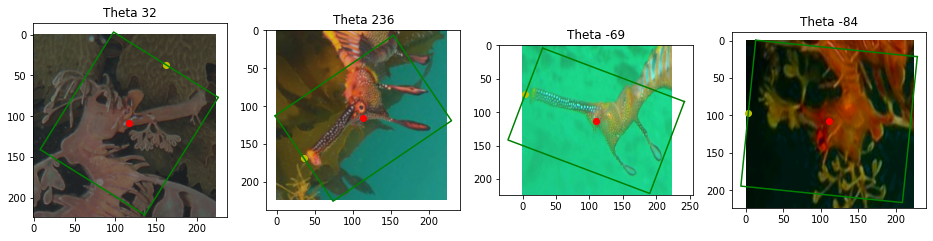

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(4*4, 1*4))
for c in range(4):
    plot_image_coordinates(ax[c], 
                           images_un[c].numpy().transpose((1,2,0)), 
                           xc[c].numpy()*cfg.MODEL.IMSIZE[0], 
                           yc[c].numpy()*cfg.MODEL.IMSIZE[0], 
                           xt[c].numpy()*cfg.MODEL.IMSIZE[0], 
                           yt[c].numpy()*cfg.MODEL.IMSIZE[0], 
                           w[c].numpy()*cfg.MODEL.IMSIZE[0])
    ax[c].set_title('Theta {:.0f}'.format(math.degrees(theta[c])))

# Models

In [5]:
import models

In [6]:
cfg.MODEL

CfgNode({'CORE_NAME': 'hrnet', 'PRETRAINED': 'models/hrnetv2_w32_imagenet_pretrained.pth', 'IMSIZE': [224, 224], 'PREDICT_THETA': False, 'EXTRA': CfgNode({'STAGE1': CfgNode({'NUM_MODULES': 1, 'NUM_RANCHES': 1, 'BLOCK': 'BOTTLENECK', 'NUM_BLOCKS': [4], 'NUM_CHANNELS': [64], 'FUSE_METHOD': 'SUM'}), 'STAGE2': CfgNode({'NUM_MODULES': 1, 'NUM_BRANCHES': 2, 'BLOCK': 'BASIC', 'NUM_BLOCKS': [4, 4], 'NUM_CHANNELS': [32, 64], 'FUSE_METHOD': 'SUM'}), 'STAGE3': CfgNode({'NUM_MODULES': 4, 'NUM_BRANCHES': 3, 'BLOCK': 'BASIC', 'NUM_BLOCKS': [4, 4, 4], 'NUM_CHANNELS': [32, 64, 128], 'FUSE_METHOD': 'SUM'}), 'STAGE4': CfgNode({'NUM_MODULES': 3, 'NUM_BRANCHES': 4, 'BLOCK': 'BASIC', 'NUM_BLOCKS': [4, 4, 4, 4], 'NUM_CHANNELS': [32, 64, 128, 256], 'FUSE_METHOD': 'SUM'})})})

In [7]:
model = models.orientation_net.OrientationNet(cfg, True)

In [8]:
images = torch.randn(4, 3, 224, 224)

In [9]:
output = model(images)

In [10]:
output.shape

torch.Size([4, 5])

# Theta angle to class

In [ ]:
te = [train_dataset[i][-1] for i in range(20)]
te

In [ ]:
for i, t in enumerate(te):
    print("{:.3f}\t {:.3f}\t {:.3f}\t {:.3f}".format(t, math.cos(t), ten[i], math.cos(ten[i])))

In [ ]:
np.arccos(np.cos(te))

In [ ]:
list(range(0, 8, 2))

# Evaluate predicted theta

In [3]:
import pickle

In [4]:
ds = 'whaleshark'
exp = 'best'

In [5]:
with open('output/{}_{}/theta_gt.pkl'.format(ds, exp), 'rb') as file:
    theta_gt = pickle.load(file)

In [6]:
theta_gt

array([ 0.09966865,  0.17670886,  0.05675716, -0.1450417 , -0.069886  ,
        0.39670867,  0.11649146, -0.3893167 , -0.11291966, -0.19118446,
        0.05549851,  0.14531001, -0.11710875,  0.24497867,  0.05097621,
       -0.03958327,  1.1773456 , -0.14373867, -0.13888502,  0.08200745,
       -0.069886  ,  0.06374332,  0.10244385, -0.22423474,  0.08887418,
        0.11773258, -0.21608497, -0.06532747, -0.03668079,  0.06720632,
       -0.29849893,  0.03060269,  0.18164884,  0.38687572,  0.0863234 ,
       -0.08413824,  0.08964672,  0.05945366,  0.08887418,  0.28212374,
       -0.29736516,  0.05992816,  0.01868941, -0.09585915,  0.24017102,
        0.41822433,  0.5271459 ,  0.39644128, -0.12102722, -0.28897542,
       -0.05150081,  0.19968389, -0.11220282, -0.10340346,  0.0863234 ,
       -0.18272156,  0.0192284 ,  0.11598198,  0.07937831,  0.02777064,
        0.04038208,  0.06186784,  0.08620557,  0.08145204, -0.27970415,
       -0.15176515,  0.10168885, -0.20749623, -0.0863234 , -0.19

In [7]:
with open('output/{}_{}/theta_preds.pkl'.format(ds, exp), 'rb') as file:
    theta_pred = pickle.load(file)

In [8]:
theta_pred

array([-3.78693342e-02,  8.34993124e-02,  7.86293745e-02,  2.98837423e-02,
       -5.76900244e-02,  3.11375022e-01,  2.48486996e-02, -2.08943009e-01,
       -1.36186004e-01, -6.05243444e-02,  7.26991892e-02,  2.85632610e-02,
       -6.02480173e-02,  2.35037804e-01,  7.47308731e-02,  4.18512821e-02,
       -5.32859564e-02, -4.87116575e-02, -8.25964212e-02,  1.99732423e-01,
       -6.02899790e-02, -1.30176544e-04,  3.34770679e-01, -2.14420915e-01,
        3.43335867e-02,  5.09284735e-02, -1.04983568e-01, -9.92649794e-02,
       -1.63112044e-01,  2.12526321e-02, -3.79866838e-01, -1.44771338e-02,
       -5.71870804e-03,  4.05556560e-01,  1.12620831e-01, -1.47187948e-01,
        1.16424203e-01,  3.94618511e-02,  5.55801392e-02,  2.70622373e-01,
       -2.52085447e-01,  5.58884144e-02, -1.05531216e-02, -1.01145387e-01,
        2.53378153e-02,  1.16486549e-01,  6.20651960e-01,  9.28218007e-01,
       -1.30970955e-01,  2.01577902e-01, -3.14964056e-02, -4.99552488e-02,
       -5.23277521e-02, -

In [9]:
from core.evaluate import normalize_theta
np_norm_theta = np.vectorize(normalize_theta)
theta_pred = np.rad2deg(theta_pred)
theta_gt = np.rad2deg(theta_gt)
err_theta = np.abs(np_norm_theta(theta_pred) - np_norm_theta(theta_gt))

In [10]:
err_theta = np_norm_theta(err_theta)

In [11]:
err_theta = np.abs(err_theta)

Text(0, 0.5, 'Number of images')

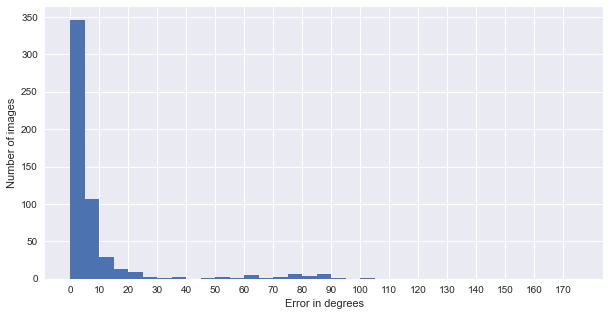

In [16]:
import matplotlib.style as style
style.use('seaborn')

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(err_theta, bins=list(range(0, 180, 5)))
ax.set_xticks(list(range(0, 180, 10)))
ax.set_xlabel('Error in degrees')
ax.set_ylabel('Number of images')

In [23]:
err_theta

array([5.246169 , 2.1153822, 5.094016 , 1.9703865, 4.782289 , 2.3191457,
       4.259802 , 4.4219413, 0.7948382, 4.0608635], dtype=float32)

Text(0, 0.5, 'Number of images')

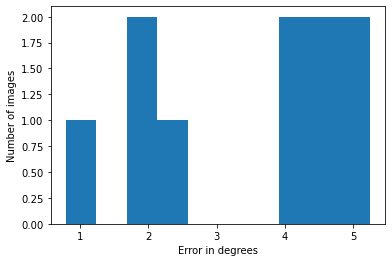

In [35]:
plt.hist(err_theta)
plt.xlabel('Error in degrees')
plt.ylabel('Number of images')

# Test EfficientNet

In [1]:
from efficientnet_pytorch import EfficientNet

In [2]:
model = EfficientNet.from_pretrained('efficientnet-b4')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /home/olga/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100.0%


Loaded pretrained weights for efficientnet-b4


In [3]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

# Test WBIA plugin - orientation

In [1]:
import wbia
import wbia_pie_pytorch
from wbia.init import sysres
dbdir = sysres.ensure_testdb_orientation()
ibs = wbia.opendb(dbdir=dbdir)
aid_list = ibs.get_valid_aids()
aid_list = aid_list[:3]

VTOOL BACKEND FOR pyflann = <module 'pyflann' from '/home/olga/anaconda3/envs/wildme/lib/python3.7/site-packages/pyflann/__init__.py'>
VTOOL BACKEND FOR FLANN_CLS = <class 'pyflann.index.FLANN'>
[pydarknet] CPU fallback for: pydarknet_cuda


/home/olga/anaconda3/envs/wildme/lib/python3.7/site-packages/wbia/plottool/__MPL_INIT__.py:176: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams[key] = ''


# Create COCO annotations from json file

In [3]:
import wbia
import os

In [4]:
testdb_name = os.path.join('reid-data', 'testdb_whale_sharks')
test_ibs = wbia.opendb(testdb_name, allow_newdir=True)

[ensuredir] checkpath('/home/olga/projects_anaconda/reid-data/testdb_whale_sharks')
[ensuredir] ... does not exist
[util_path] mkdir('/home/olga/projects_anaconda/reid-data/testdb_whale_sharks')
[update_schema_version] checkpath('/home/olga/projects_anaconda/reid-data/testdb_whale_sharks/_ibsdb/_ibeis_database_backup_v0.0.0.sqlite3')
[update_schema_version] ... does not exist
[util_path] [Copying]: 
[C] | /home/olga/projects_anaconda/reid-data/testdb_whale_sharks/_ibsdb/_ibeis_database.sqlite3
[C] ->/home/olga/projects_anaconda/reid-data/testdb_whale_sharks/_ibsdb/_ibeis_database_backup_v0.0.0.sqlite3
[pref] Saving to /home/olga/projects_anaconda/reid-data/testdb_whale_sharks/____.cPkl

[util_list] +--- DEBUG DUPLICATE ITEMS  'visual_uuid_list' ---
[util_list] |There are 0 duplicates
[util_list] L--- FINISH DEBUG DUPLICATE ITEMS ---

[update_schema_version] checkpath('/home/olga/projects_anaconda/reid-data/testdb_whale_sharks/_ibsdb/_ibeis_staging_backup_v0.0.0.sqlite3')
[update_schema

In [5]:
json_file = 'wbia_pie_pytorch/reid-data/query.json'
#source_dir = 'wbia_pie_pytorch/reid-data/whaleshark_cropped/original/'

In [6]:
from wbia_pie_pytorch.utils import read_json

In [7]:
test_annots = read_json(json_file)
print('Found {} records in demo db'.format(len(test_annots)))

Found 1301 records in demo db


In [9]:
gpaths = [record[0] for record in test_annots]
names = [record[1] for record in test_annots]

In [10]:
gid_list = test_ibs.add_images(gpaths)
nid_list = test_ibs.add_names(names)

[generate2] executing 1301 parse_imageinfo tasks using 7 futures procs
(pargen) parse_imageinfo:  1301/1301...  rate=1077.34 iter/sec,  etr=0:00:00, ellapsed=0:00:01, wall=21:34 AEST 
Copying    1/?...  rate=4917.10 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=7384.28 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9383.14 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9641.99 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8456.19 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9619.87 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=10082.36 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=7294.39 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6909.84 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=7928.68 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9019.93 sec

Copying    1/?...  rate=6887.15 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=7825.13 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=4036.85 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=5769.30 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=5907.44 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8962.11 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8507.64 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=2029.17 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8338.51 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=5309.22 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6657.58 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6307.18 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6195.39 sec/iter,  ellapsed=0:00:00, wal

Copying    1/?...  rate=6278.86 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6754.07 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6775.89 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6764.96 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=7133.12 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6533.14 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6326.21 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=3637.72 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=2590.67 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=5236.31 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=7653.78 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8175.96 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8793.01 sec/iter,  ellapsed=0:00:00, wal

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Copying    1/?...  rate=5269.20 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=4911.34 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=5077.82 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6316.68 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=7767.17 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=7121.01 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8923.97 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8542.30 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8683.78 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6195.39 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8981.30 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=2068.19 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=7449.86 sec/iter,  ellapsed=0:00:00, wa

Copying    1/?...  rate=6764.96 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8175.96 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=5940.91 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8738.06 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=4707.39 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6131.99 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6222.96 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=4232.38 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=5714.28 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=7449.86 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8019.64 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8683.78 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9019.93 sec/iter,  ellapsed=0:00:00, wal

Copying    1/?...  rate=6186.25 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6177.14 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=5991.83 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6875.86 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6636.51 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6775.89 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=5957.78 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6563.81 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6764.96 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6842.21 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=7752.81 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9597.86 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9157.79 sec/iter,  ellapsed=0:00:00, wal

Copying    1/?...  rate=9799.68 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=10010.17 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9446.54 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9279.35 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8962.11 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8388.54 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9754.10 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9532.42 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9892.13 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9320.59 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9404.18 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9686.52 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8886.16 sec/iter,  ellapsed=0:00:00, wa

Copying    1/?...  rate=9467.87 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=5547.99 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9320.59 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=9446.54 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=10356.20 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=10754.51 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=1495.83 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=8719.89 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=6615.58 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=4228.11 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=2571.61 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=3876.42 sec/iter,  ellapsed=0:00:00, wall=21:34 AEST 
Copying    1/?...  rate=3650.38 sec/iter,  ellapsed=0:00:00, w

In [22]:
species = ['whale_shark'] * len(gid_list)

In [15]:
# these images are pre-cropped aka trivial annotations
wh_list = test_ibs.get_image_sizes(gid_list)
bbox_list = [[0, 0, w, h] for (w, h) in wh_list]

In [24]:
test_ibs.add_annots(
            gid_list, bbox_list=bbox_list, species_list=species, 
            nid_list=nid_list
        )

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [30]:
test_ibs.get_name_texts([1])

['A-369_left']

In [32]:
import utool as ut

In [ ]:
db_fname = demo_db_url.split('/')[-1]
demo_db_url = 
ut.grab_zipped_url(demo_db_url, appname='wbia_pie_pytorch', check_hash=True, fname=db_fname)

# Make demo db from json file
In case I need to recompile example

In [39]:
json_file = 'wbia_pie_pytorch/reid-data/query.json'
targer_image_dir = 'wbia_pie_pytorch/reid-data/whaleshark_cropped/demo_db/images/test2021'
targer_annot_dir = 'wbia_pie_pytorch/reid-data/whaleshark_cropped/demo_db/annotations'
annot_filename = 'instances_test2021.json'

In [40]:
os.makedirs(targer_annot_dir, exist_ok=True)
os.makedirs(targer_image_dir, exist_ok=True)

In [41]:
test_annots = read_json(json_file)
print('Found {} records in demo db'.format(len(test_annots)))

Found 1301 records in demo db


In [43]:
import shutil
import imageio

In [55]:
annotations = []
images = []

for idx, record in enumerate(test_annots):
    image_path = record[0]
    name = record[1]
    viewpoint = record[2]
    source_basename = os.path.split(image_path)[-1]
    target_path = os.path.join(targer_image_dir, source_basename)
    shutil.copyfile(image_path, target_path)
    # these images are pre-cropped aka trivial annotations
    h, w = imageio.imread(image_path).shape[:2]
    bbox = [0, 0, w, h]
    image = {'license': 1,
             'file_name': source_basename,
             'photographer': '',
             'coco_url': None,
             'height': h,
             'width': w,
             'date_captured': 'NA',
             'gps_lat_captured': '-1.000000',
             'gps_lon_captured': '-1.000000',
             'flickr_url': None,
             'id': idx}
    annot = {'bbox': bbox,
              'theta': 0.0,
              'viewpoint': viewpoint,
              'segmentation': [[0, 0, h, 0, h, w, 0, w, 0, 0]],
              'segmentation_bbox': [0, 0, w, h],
              'area': h*w,
              'iscrowd': 0,
              'id': idx,
              'image_id': idx,
              'category_id': 0,
              'individual_ids': [],
              'isinterest': 0,
              'name': name}
    annotations.append(annot)
    
    images.append(image)
    annotations.append(annot)

In [54]:
h, w = imageio.imread(test_annots[1][0]).shape[:2]
h, w

(289, 256)

In [51]:
image.shape[:2]

(289, 256)

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

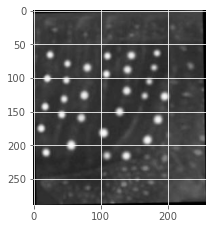

In [53]:
plt.imshow(image)

# EfficientNet testing

In [1]:
from efficientnet_pytorch import EfficientNet

In [44]:
model = EfficientNet.from_name('efficientnet-b7')

In [10]:
EfficientNet.get_image_size('efficientnet-b4')

380

In [13]:
EfficientNet.

efficientnet_pytorch.model.EfficientNet

In [21]:
from efficientnet_pytorch import utils

In [22]:
utils.

<module 'efficientnet_pytorch.utils' from '/home/olga/anaconda3/envs/wildme/lib/python3.7/site-packages/efficientnet_pytorch/utils.py'>

In [3]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [45]:
import torch
img = torch.rand(2, 3, 380, 380)

In [46]:
out = model.extract_features(img)
out.shape

torch.Size([2, 2560, 12, 12])

In [47]:
from wbia_pie_pytorch.models.efficientnet import EfficientNetReid

In [48]:
model = EfficientNetReid('efficientnet-b4', 314, [512])

Loaded pretrained weights for efficientnet-b4


In [49]:
model

EfficientNetReid(
  (core_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )


In [50]:
def epoch_in_ranges(epoch, ranges):
    """ Check if epoch in specified ranges
    Input:
        epoch (int): index of epoch
        ranges (list of tuples): returns True if epoch in one of ranges
    """
    for rng in ranges:
        if epoch >= rng[0] and epoch < rng[1]:
            return True
    return False

In [55]:
epoch_in_ranges(102, [(0, 5), (50, 55), (100, 105), (150, 155)])

True